<a href="https://colab.research.google.com/github/supersfel/AI-Python/blob/main/09_pre_trained_vggnet_cats_vs_dogs_dataset_finetuning_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 라이브러리 import

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
IMG_SIZE = 160  # All images will be resized to 160x160

In [ ]:
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

# Cat vs Dogs Dataset 다운받고 불러오기
## Reference : https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4IKHBM/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
type(raw_train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
raw_train

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
raw_validation

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
raw_test

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [ ]:
get_label_name = metadata.features['label'].int2str

In [ ]:
get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=tf.int64, num_classes=2)>

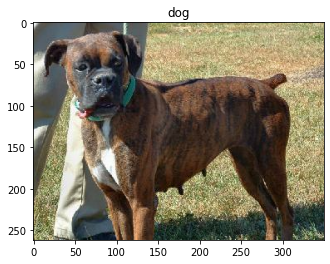

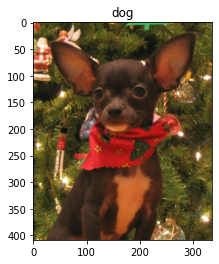

In [ ]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))
  plt.show()

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

In [ ]:
print(image_batch.shape)

(32, 160, 160, 3)


In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
print(len(model.trainable_variables))

2


In [ ]:
initial_epochs = 10
validation_steps = 20

In [ ]:
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 5s 66ms/step - loss: 0.8759 - accuracy: 0.4630


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.87
initial accuracy: 0.47


# 1) 첫번째 Training - Classifier 부분만 Fine-Tuning

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 76s 126ms/step - loss: 0.6336 - accuracy: 0.5708 - val_loss: 0.5426 - val_accuracy: 0.6728
Epoch 2/10
582/582 [==============================] - 69s 117ms/step - loss: 0.4887 - accuracy: 0.7560 - val_loss: 0.4353 - val_accuracy: 0.7923
Epoch 3/10
582/582 [==============================] - 69s 116ms/step - loss: 0.4035 - accuracy: 0.8245 - val_loss: 0.3681 - val_accuracy: 0.8435
Epoch 4/10
582/582 [==============================] - 69s 116ms/step - loss: 0.3495 - accuracy: 0.8529 - val_loss: 0.3250 - val_accuracy: 0.8659
Epoch 5/10
582/582 [==============================] - 69s 116ms/step - loss: 0.3138 - accuracy: 0.8694 - val_loss: 0.2960 - val_accuracy: 0.8749
Epoch 6/10
582/582 [==============================] - 70s 117ms/step - loss: 0.2887 - accuracy: 0.8790 - val_loss: 0.2750 - val_accuracy: 0.8831
Epoch 7/10
582/582 [==============================] - 70s 118ms/step - loss: 0.2699 - accuracy: 0.8866 - val_loss: 0.2593 - val_ac

In [ ]:
print(type(history.history))

<class 'dict'>


In [ ]:
history.history

{'accuracy': [0.570768415927887,
  0.7560451626777649,
  0.8245029449462891,
  0.8528748154640198,
  0.8693712949752808,
  0.8790435194969177,
  0.8866201043128967,
  0.892745852470398,
  0.8968833684921265,
  0.9014508128166199],
 'loss': [0.6335586309432983,
  0.48874199390411377,
  0.4035114645957947,
  0.3495109975337982,
  0.3138013780117035,
  0.2886630594730377,
  0.26991477608680725,
  0.2554422914981842,
  0.2437172532081604,
  0.23411910235881805],
 'val_accuracy': [0.6728289127349854,
  0.7923473715782166,
  0.8435081839561462,
  0.8658641576766968,
  0.87489253282547,
  0.8830610513687134,
  0.8907996416091919,
  0.8972485065460205,
  0.9041272401809692,
  0.9041272401809692],
 'val_loss': [0.5425719022750854,
  0.4352560341358185,
  0.3681371510028839,
  0.32503369450569153,
  0.29598546028137207,
  0.2749524414539337,
  0.2592758536338806,
  0.24681121110916138,
  0.23677244782447815,
  0.2285512089729309]}

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

## 학습 결과 시각화

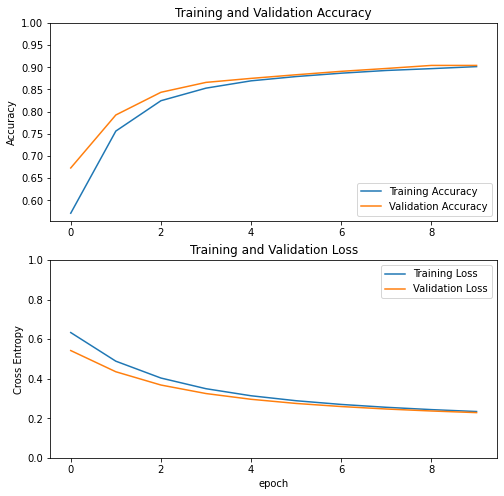

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 2) 두번째 Training - 앞에 5개 Conv Layer 부분까지 Fine-Tuning

In [ ]:
len(base_model.layers)

19

In [ ]:
# set fine-tuning layers
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 7,079,937
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
print(len(model.trainable_variables))

8


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                          epochs=total_epochs,
                          initial_epoch =  history.epoch[-1],
                          validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 80s 133ms/step - loss: 0.1570 - accuracy: 0.9325 - val_loss: 0.1236 - val_accuracy: 0.9536
Epoch 11/20
582/582 [==============================] - 78s 132ms/step - loss: 0.0906 - accuracy: 0.9613 - val_loss: 0.1108 - val_accuracy: 0.9561
Epoch 12/20
582/582 [==============================] - 79s 133ms/step - loss: 0.0678 - accuracy: 0.9720 - val_loss: 0.1018 - val_accuracy: 0.9553
Epoch 13/20
582/582 [==============================] - 78s 132ms/step - loss: 0.0497 - accuracy: 0.9811 - val_loss: 0.1269 - val_accuracy: 0.9561
Epoch 14/20
582/582 [==============================] - 78s 132ms/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.1260 - val_accuracy: 0.9592
Epoch 15/20
582/582 [==============================] - 78s 132ms/step - loss: 0.0295 - accuracy: 0.9910 - val_loss: 0.1016 - val_accuracy: 0.9617
Epoch 16/20
582/582 [==============================] - 78s 132ms/step - loss: 0.0215 - accuracy: 0.9937 - val_loss: 0.1549 -

In [ ]:
history_fine.history

{'accuracy': [0.9431488513946533,
  0.9651800394058228,
  0.9747985005378723,
  0.982428789138794,
  0.9881783723831177,
  0.9918860793113708,
  0.9941966533660889,
  0.9958087205886841,
  0.9974744915962219,
  0.9980118274688721,
  0.9986029267311096],
 'loss': [0.13351036608219147,
  0.08491019904613495,
  0.0628516748547554,
  0.04732240363955498,
  0.03400827571749687,
  0.025868091732263565,
  0.018353654071688652,
  0.014174485579133034,
  0.009949726052582264,
  0.0074955616146326065,
  0.00590389221906662],
 'val_accuracy': [0.9535683393478394,
  0.9561479091644287,
  0.9552880525588989,
  0.9561479091644287,
  0.9591573476791382,
  0.9617368578910828,
  0.9587274193763733,
  0.9630266427993774,
  0.9630266427993774,
  0.9630266427993774,
  0.9643164277076721],
 'val_loss': [0.12358281016349792,
  0.11082663387060165,
  0.10184099525213242,
  0.12690366804599762,
  0.1260426938533783,
  0.1015901267528534,
  0.1548551619052887,
  0.11793380230665207,
  0.12689943611621857,
  0.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

## 학습 결과 시각화

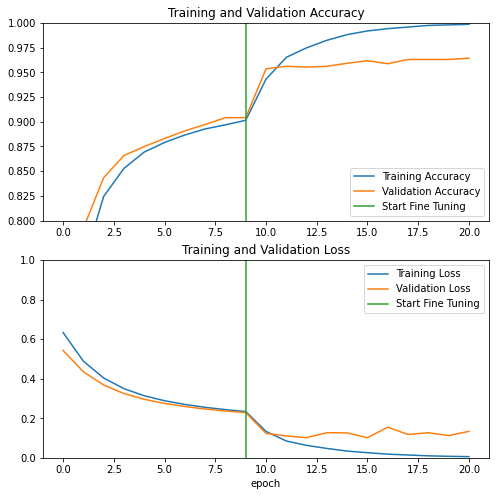

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()